# Generating Coordinates for TIFF-Based Kerchunk Reference Recipes

In this tutorial we will demonstrate how to use `xrefcoord` to generate coordinates for a reference dataset create using `Kerchunk`. Initially we will build a reference dataset from a collection of TIFF files using `Kerchunk`, then we will use `xrefcoord` to generate coordinates for the dataset.


## Background

When using `Kerchunk` with TIFF files, no coordinate information is saved within the reference file. Because of this, when accessing the reference dataset with `Xarray`, no coordinates are accessable and selection is only possible by dimensions. 

This utilty / `Xarray` accessor, uses geospatial metadata from the reference files attributes to generate coordinates on access time. 

## Building a Reference Dataset with Kerchunk

In [1]:
import fsspec
import requests
import glob
import numpy as np

import s3fs
import xarray as xr
from kerchunk.tiff import tiff_to_zarr
from kerchunk.combine import MultiZarrToZarr

from tempfile import TemporaryDirectory
import dask
import ujson
import xrefcoord  # noqa
from distributed import Client
import logging
import warnings


import imagecodecs.numcodecs

imagecodecs.numcodecs.register_codecs()

## Data Source

For this example, we will read a collection of TIFF files stored on `s3`. These TIFFs are from the Sentinel 2 mission and are gridded Aerosol Optical Thickness (AOT) data products.


In [2]:
# Initial an fsspec filesystem to read files over s3.
fs_read = fsspec.filesystem("s3", anon=True, skip_instance_cache=True)

# Here we use fsspec's glob feature to grab the matching files at a specified path.
files_paths = fs_read.glob("s3://sentinel-cogs/sentinel-s2-l2a-cogs/44/P/MT/2022/5/*/AOT.tif")

# Prepend 's3://'
file_pattern = sorted(["s3://" + f for f in files_paths])

### Examine a Single TIFF 
Here we are opening up a single TIFF with `Xarray` and `rioxarray`.

In [3]:
%%time

xr_ds = xr.open_dataset(file_pattern[0], chunks="auto", engine="rasterio")
xr_ds

CPU times: user 270 ms, sys: 27.2 ms, total: 297 ms
Wall time: 576 ms


<xarray.Dataset>
Dimensions:      (band: 1, x: 1830, y: 1830)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4.001e+05 ... 5.097e+05 5.097e+05
  * y            (y) float64 1.3e+06 1.3e+06 1.3e+06 ... 1.19e+06 1.19e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>

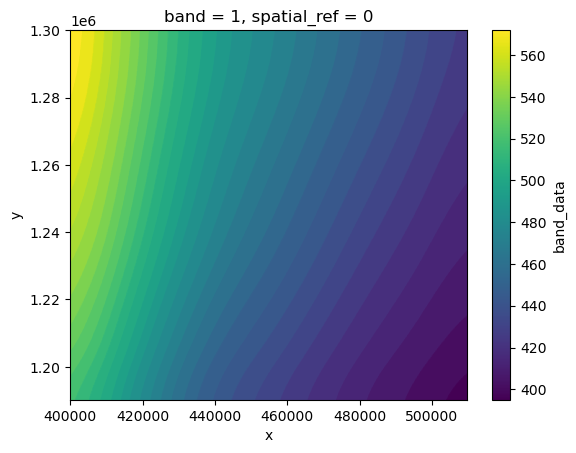

In [4]:
xr_ds.band_data.load().plot()

## Start a Dask Client for Multiprocessing
Here we will initiate a `Dask` client for parallel processing as well as specify a temporary directory for storing the references.

In [5]:
# Setup some fsspec kwargs
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

# Create a temp directory
td = TemporaryDirectory()
temp_dir = td.name

# Start a Dask client
client = Client(n_workers=8, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/maxrjones/science/proxy/8787/status,
Dashboard: /user/maxrjones/science/proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 30.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32883,Workers: 8
Dashboard: /user/maxrjones/science/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 30.91 GiB
Comm: tcp://127.0.0.1:46547,Total threads: 1
Dashboard: /user/maxrjones/science/proxy/41567/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:38577,


## Create Reference Files using Kerchunk

In [6]:
# Use Kerchunk's `SingleHdf5ToZarr` method to create a reference file.


def generate_json_reference(fil, output_dir: str):
    h5chunks = tiff_to_zarr(fil, remote_options={"protocol": "s3"})
    fname = fil.split("/")[-2]
    outf = f"{output_dir}/{fname}.json"
    with open(outf, "wb") as f:
        f.write(ujson.dumps(h5chunks).encode())
    return outf


# Generate Dask Delayed objects
tasks = [dask.delayed(generate_json_reference)(fil, temp_dir) for fil in file_pattern]

### Start Dask Compute

In [7]:
warnings.filterwarnings("ignore")
dask.compute(tasks)

(['/tmp/tmp7yst6xf_/S2A_44PMT_20220505_0_L2A.json',
  '/tmp/tmp7yst6xf_/S2A_44PMT_20220515_0_L2A.json',
  '/tmp/tmp7yst6xf_/S2A_44PMT_20220525_0_L2A.json',
  '/tmp/tmp7yst6xf_/S2B_44PMT_20220510_0_L2A.json',
  '/tmp/tmp7yst6xf_/S2B_44PMT_20220520_0_L2A.json',
  '/tmp/tmp7yst6xf_/S2B_44PMT_20220530_0_L2A.json'],)

## Combine Reference Files into Multi-File Reference Dataset

Now we will combine all the reference files generated into a single reference dataset. Since each TIFF file is a single timeslice and the only temporal information is stored in the filepath, we will have to specify the `coo_map` kwarg in `MultiZarrToZarr` to build a dimension from the filepath attributes. 



In [8]:
# Custom Kerchunk function from `coo_map` to create dimensions
def fn_to_time(index, fs, var, fn):
    import re
    import datetime

    subst = fn.split("/")[-2].split("_")[2]
    return datetime.datetime.strptime(subst, "%Y%m%d")


mzz = MultiZarrToZarr(
    path=files_paths,
    indicts=sorted(glob.iglob(f"{temp_dir}/*.json")),
    remote_protocol="s3",
    coo_map={"time": fn_to_time},
    coo_dtypes={"time": np.dtype("M8[s]")},
    concat_dims=["time"],
    identical_dims=["X", "Y"],
)

# save translate reference in memory for later visualization
multi_kerchunk = mzz.translate()

# Write kerchunk .json record
output_fname = "AOT_combined.json"
with open(f"{output_fname}", "wb") as f:
    f.write(ujson.dumps(multi_kerchunk).encode())

## Open Combined Reference Dataset

In [9]:
fs = fsspec.filesystem(
    "reference",
    fo="AOT_combined.json",
    remote_protocol="s3",
    remote_options={"anon": True},
    skip_instance_cache=True,
)
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr")

In [10]:
ds

<xarray.Dataset>
Dimensions:  (time: 6, Y: 1830, X: 1830, Y1: 915, X1: 915, Y2: 458, X2: 458,
              Y3: 229, X3: 229)
Coordinates:
  * time     (time) datetime64[s] 2022-05-05 2022-05-10 ... 2022-05-30
Dimensions without coordinates: Y, X, Y1, X1, Y2, X2, Y3, X3
Data variables:
    0        (time, Y, X) float32 ...
    1        (time, Y1, X1) float32 ...
    2        (time, Y2, X2) float32 ...
    3        (time, Y3, X3) float32 ...
Attributes: (12/14)
    multiscales:             [{'datasets': [{'path': '0'}, {'path': '1'}, {'p...
    OVR_RESAMPLING_ALG:      MODE
    KeyDirectoryVersion:     1
    KeyRevision:             1
    KeyRevisionMinor:        0
    GTModelTypeGeoKey:       1
    ...                      ...
    GeogCitationGeoKey:      WGS 84
    GeogAngularUnitsGeoKey:  9102
    ProjectedCSTypeGeoKey:   32644
    ProjLinearUnitsGeoKey:   9001
    ModelPixelScale:         [60.0, 60.0, 0.0]
    ModelTiepoint:           [0.0, 0.0, 0.0, 399960.0, 1300020.0, 0.0]

## Use `xrefcoord` to Generate Coordinates

In [11]:
# Specify dimension names (time, y, y)
ref_ds = ds.xref.generate_coords(time_dim_name="time", x_dim_name="X", y_dim_name="Y")
ref_ds = ref_ds.rename({"0": "AOT"})

numcodec 'imagecodecs_aec' already registered
numcodec 'imagecodecs_apng' already registered
numcodec 'imagecodecs_avif' already registered
numcodec 'imagecodecs_bitorder' already registered
numcodec 'imagecodecs_bitshuffle' already registered
numcodec 'imagecodecs_blosc' already registered
numcodec 'imagecodecs_blosc2' already registered
numcodec 'imagecodecs_brotli' already registered
numcodec 'imagecodecs_byteshuffle' already registered
numcodec 'imagecodecs_bz2' already registered
numcodec 'imagecodecs_cms' already registered
numcodec 'imagecodecs_deflate' already registered
numcodec 'imagecodecs_delta' already registered
numcodec 'imagecodecs_float24' already registered
numcodec 'imagecodecs_floatpred' already registered
numcodec 'imagecodecs_gif' already registered
numcodec 'imagecodecs_heif' already registered
numcodec 'imagecodecs_jetraw' already registered
numcodec 'imagecodecs_jpeg' already registered
numcodec 'imagecodecs_jpeg2k' already registered
numcodec 'imagecodecs_jpeg

## Plot a Map

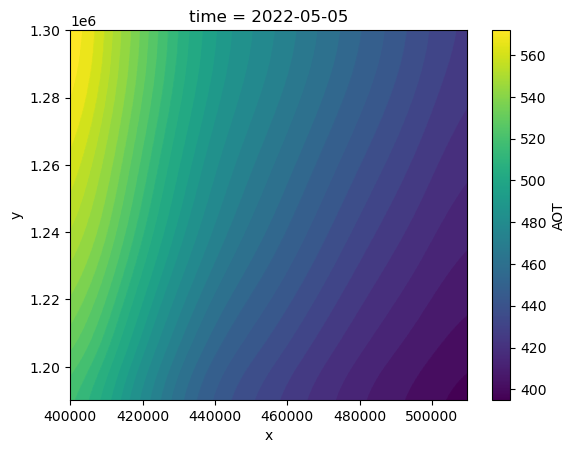

In [12]:
ref_ds["AOT"].isel(time=0).plot()

## Create a Time-Series

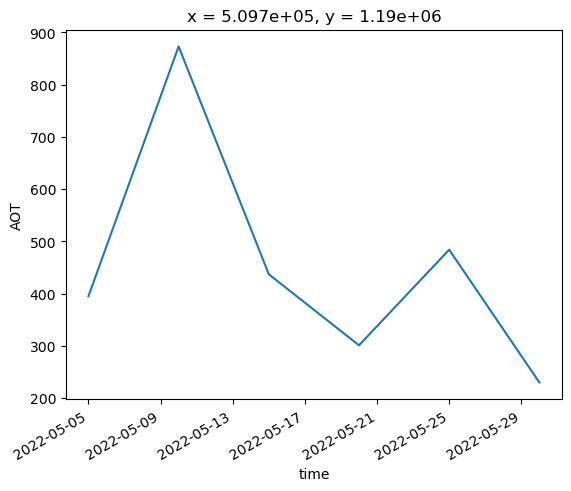

In [13]:
ref_ds["AOT"].sel(y=ref_ds.x.mean(), x=ref_ds.y.mean(), method="nearest").plot()